In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import string
import random
from typing import List, Tuple
import math
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import log
import mynlputils as nu

In [2]:
logger = log.get_logger(__name__)

In [3]:
@nu.timer
def load_data(raw_txt_train_path: str, raw_txt_test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train = pd.read_csv(raw_txt_train_path, header=None, names=["label", "title", "description"])
    df_test = pd.read_csv(raw_txt_test_path, header=None, names=["label", "title", "description"])
    return df_train[["label", "description"]], df_test[["label", "description"]]

@nu.timer
def create_validation_set(corpus: pd.DataFrame, valid_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_corpus, valid_corpus = train_test_split(corpus, test_size=valid_size, random_state=1)
    return train_corpus.reset_index(drop=True), valid_corpus.reset_index(drop=True)

@nu.timer
def clean_text(docs: pd.DataFrame) -> pd.DataFrame:
    clean_docs = docs['description']
    clean_docs = clean_docs.str.replace("-", " ")
    clean_docs = clean_docs.str.replace("quot;", " ")
    clean_docs = clean_docs.str.replace("#39;s", "'")
    translation_table = str.maketrans('', '', string.punctuation)
    clean_docs = clean_docs.str.translate(translation_table)
    clean_docs = clean_docs.str.lower()
    clean_docs = clean_docs.str.replace(r'\d+', ' <NUM> ')
    clean_docs = clean_docs.str.replace(r'\s+', ' ')
    return clean_docs.to_frame()

@nu.timer
def split_docs(docs: pd.DataFrame) -> pd.DataFrame:
    return docs['description'].str.split().to_list()

@nu.timer
def tokenize(tokens: List[List[str]], min_freq: int = 5):
    word_freq = Counter([word for sentence in tokens for word in sentence])
    vocab = [word for word, freq in word_freq.items() if freq >= min_freq]
    vocab = ['<PAD>', '<UNK>'] + vocab
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx_tokens = [[word2idx.get(word, 1) for word in sentence] for sentence in tokens]
    return vocab, idx_tokens, word2idx

@nu.timer
def create_skipgrams(corpus, window_size, pad_idx):
    data = []
    for sentence in corpus:
        padded_sentence = [pad_idx] * window_size + sentence + [pad_idx] * window_size
        for word_index in range(window_size, len(padded_sentence) - window_size):
            contexts = padded_sentence[word_index - window_size : word_index] + padded_sentence[word_index + 1 : word_index + window_size + 1]
            data.append((contexts, padded_sentence[word_index]))
    return data

@nu.timer
def create_batches(skipgrams, word2idx, pad_idx, batch_size=32, num_neg_samples=5):
    words_list = list(word2idx.keys())
    vocab_size = len(words_list)
    n = len(skipgrams)

    # Shuffle skipgrams
    random.shuffle(skipgrams)

    batches = []

    for batch_start in range(0, n, batch_size):
        context_batch = []
        target_batch = []
        negative_batch = []

        # Create batches
        for contexts, target in skipgrams[batch_start:batch_start + batch_size]:
            negatives = [random.choice(range(vocab_size)) for _ in range(num_neg_samples)]
            context_batch.append(torch.LongTensor(contexts))
            target_batch.append(torch.LongTensor([target]))
            negative_batch.append(torch.LongTensor(negatives))

        # If this is the last batch and it's not full, skip it
        if len(context_batch) < batch_size:
            continue

        # Pad context sequences in batch
        context_batch = pad_sequence(context_batch, batch_first=True, padding_value=pad_idx)

        # Convert target and negative batches to tensors
        target_batch = torch.stack(target_batch)
        negative_batch = torch.stack(negative_batch)

        batches.append((context_batch, target_batch, negative_batch))
        
    return batches


class CBOW_NS(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CBOW_NS, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)

    def forward(self, context_words, target_word, negative_words):
        # Get embeddings for context words, target word and negative words
        context_embeds = self.embeddings(context_words)  # (batch_size, window_size*2, embed_size)
        target_embeds = self.embeddings(target_word)    # (batch_size, 1, embed_size)
        negative_embeds = self.embeddings(negative_words)# (batch_size, num_neg_samples, embed_size)

        # Sum the context word embeddings
        context_embeds_sum = torch.sum(context_embeds, dim=1, keepdim=True)  # (batch_size, 1, embed_size)

        # Compute positive score
        pos_score = torch.bmm(context_embeds_sum, target_embeds.transpose(1,2)) # (batch_size, 1, 1)
        pos_score = F.logsigmoid(pos_score)

        # Compute negative score
        neg_score = torch.bmm(context_embeds_sum, negative_embeds.transpose(1,2)) # (batch_size, 1, num_neg_samples)
        neg_score = F.logsigmoid(-neg_score)

        # Return negative of total score
        return -(torch.sum(pos_score) + torch.sum(neg_score))
    
@nu.timer
def train(model, epochs, train_batches, val_batches, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for context_batch, target_batch, negative_batch in train_batches:
            model.zero_grad()
            loss = model(context_batch, target_batch, negative_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        train_loss = total_loss / batch_count
        train_losses.append(train_loss)

        model.eval()  # set model to eval mode
        val_loss = evaluate(model, val_batches)
        val_losses.append(val_loss)

        logger.info(f'Epoch {epoch}, Train Loss: {train_losses[-1]}, Validation Loss: {val_loss[-1]}')
    return model, train_losses, val_losses


def evaluate(model, batches):
    total_loss = 0
    batch_count = 0
    with torch.no_grad():  # disable gradient computation to save memory
        for context_batch, target_batch, negative_batch in batches:
            loss = model(context_batch, target_batch, negative_batch)
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count


def plot_losses(train_losses, val_losses, epochs):
    epochs_range = list(range(1, epochs + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs_range, y=train_losses, mode='lines', name='Train Loss'))
    fig.add_trace(go.Scatter(x=epochs_range, y=val_losses, mode='lines', name='Validation Loss'))
    fig.update_layout(title='Loss over Epochs', xaxis=dict(title='Epoch'), yaxis=dict(title='Loss'))
    fig.show()

In [31]:
conf = nu.load_config("a3")

24-Jul-23 19:52:59 - INFO - Starting 'load_config'.
24-Jul-23 19:52:59 - INFO - Finished 'load_config' in 0.0256 secs.


In [4]:
# conf = nu.load_config("a3")
df_train, df_test = load_data(conf.paths.raw_txt_train, conf.paths.raw_txt_test)
df_train, df_valid = create_validation_set(df_train, 0.1)
df_train_clean = clean_text(df_train)
df_valid_clean = clean_text(df_valid)
df_test_clean = clean_text(df_test)

train_tokens = split_docs(df_train_clean)
valid_tokens = split_docs(df_valid_clean)
test_tokens = split_docs(df_test_clean)

vocab, idx_train_tokens, word2idx = tokenize(train_tokens)
_, idx_valid_tokens, _ = tokenize(valid_tokens)
_, idx_test_tokens, _ = tokenize(test_tokens)

pad_idx = word2idx['<PAD>']
skipgrams_train = create_skipgrams(idx_train_tokens, window_size=2, pad_idx=pad_idx)
skipgrams_valid = create_skipgrams(idx_valid_tokens, window_size=2, pad_idx=pad_idx)
skipgrams_test = create_skipgrams(idx_test_tokens, window_size=2, pad_idx=pad_idx)

train_batches = create_batches(skipgrams_train, word2idx, pad_idx, batch_size=512)
valid_batches = create_batches(skipgrams_valid, word2idx, pad_idx, batch_size=512)
test_batches = create_batches(skipgrams_test, word2idx, pad_idx, batch_size=512)

24-Jul-23 19:30:06 - INFO - Starting 'load_config'.
24-Jul-23 19:30:06 - INFO - Finished 'load_config' in 0.0196 secs.
24-Jul-23 19:30:06 - INFO - Starting 'load_data'.
24-Jul-23 19:30:06 - INFO - Finished 'load_data' in 0.3146 secs.
24-Jul-23 19:30:06 - INFO - Starting 'create_validation_set'.
24-Jul-23 19:30:06 - INFO - Finished 'create_validation_set' in 0.0076 secs.
24-Jul-23 19:30:06 - INFO - Starting 'clean_text'.
/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_25296/2887024429.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_docs = clean_docs.str.replace(r'\d+', ' <NUM> ')
/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_25296/2887024429.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_docs = clean_docs.str.replace(r'\s+', ' ')
24-Jul-23 19:30:07 - INFO - Finished 'clean_text' in 1.4201 secs.
24-Jul-23 19:30:07 - INFO - Starting 'clean_text

In [7]:
vocab_size = len(vocab)
model = CBOW_NS(vocab_size, conf.model.embedding.embed_size)
trained_model, train_losses, val_losses = train(model, conf.model.embedding.epochs, train_batches, valid_batches, conf.model.embedding.lr)

24-Jul-23 19:32:17 - INFO - Starting 'train'.
24-Jul-23 19:33:21 - INFO - Epoch 0, Train Loss: 11005.139324033504, Validation Loss: 12427.67182134272
24-Jul-23 19:34:26 - INFO - Epoch 1, Train Loss: 4304.808127507672, Validation Loss: 9142.847182724501
24-Jul-23 19:35:29 - INFO - Epoch 2, Train Loss: 2716.1542937292415, Validation Loss: 6758.749054290436
24-Jul-23 19:36:31 - INFO - Epoch 3, Train Loss: 1850.9295128452666, Validation Loss: 5199.562077448918
24-Jul-23 19:37:37 - INFO - Epoch 4, Train Loss: 1382.2247705811515, Validation Loss: 4273.301761501438
24-Jul-23 19:38:41 - INFO - Epoch 5, Train Loss: 1126.8104174800965, Validation Loss: 3729.056437062693
24-Jul-23 19:39:44 - INFO - Epoch 6, Train Loss: 982.3881940734063, Validation Loss: 3406.6263769799534
24-Jul-23 19:40:47 - INFO - Epoch 7, Train Loss: 895.8516813314844, Validation Loss: 3218.291761796553
24-Jul-23 19:41:52 - INFO - Epoch 8, Train Loss: 840.1050793181545, Validation Loss: 3113.002150986221
24-Jul-23 19:42:56 - 

In [8]:
plot_losses(train_losses, val_losses, conf.model.embedding.epochs)

In [9]:
embeddings = model.embeddings.weight.data.numpy()

In [10]:
idx2word = {value: key for key, value in word2idx.items()}

In [11]:
pca = PCA(n_components=2)  # reduce to 2 components
embeddings_pca = pca.fit_transform(embeddings)

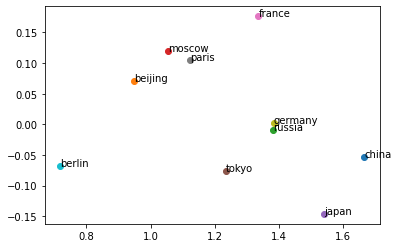

In [12]:
# Plot some words
words = ['china', 'beijing', 'russia', 'moscow', 'japan', 'tokyo', 'france', 'paris', 'germany', 'berlin']
for word in words:
    idx = word2idx[word]
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1])
    plt.annotate(word, (embeddings_pca[idx, 0], embeddings_pca[idx, 1]))
plt.show()

In [13]:
def find_closest_embeddings(embedding, word, word2idx, idx2word, n=10):
    # Get the embedding for the word
    word_embedding = embedding[word2idx[word]]

    # Compute cosine similarities between word_embedding and all embeddings
    similarities = cosine_similarity([word_embedding], embedding)[0]

    # Get the indices of the top n similar embeddings
    closest_idxs = np.argsort(similarities)[-n:]

    # Convert these indices back to words and return
    closest_words_with_distances = [(idx2word[idx], similarities[idx]) for idx in reversed(closest_idxs)]

    return closest_words_with_distances

In [14]:
sample_words = ["referendum", "venezuela", "war", "pope", "schumacher", "ferrari", "soccer", "cricket"]

In [18]:
for word in sample_words:
    print(f"Closest words to '{word}':")
    closest_words_with_distances = find_closest_embeddings(embeddings, word, word2idx, idx2word, n=5)
    for close_word, distance in closest_words_with_distances:
        print(f"{close_word}: {distance}")
    print()

Closest words to 'referendum':
referendum: 1.0000001192092896
kamal: 0.40073469281196594
recall: 0.39591097831726074
veil: 0.34378424286842346
marking: 0.3431364595890045

Closest words to 'venezuela':
venezuela: 1.0
roy: 0.4125961363315582
unsuccessful: 0.402940571308136
forcibly: 0.37566354870796204
moffett: 0.3735027611255646

Closest words to 'war':
war: 1.0
crimes: 0.5158342123031616
civil: 0.48663195967674255
terror: 0.4587789475917816
iraqi: 0.4506089687347412

Closest words to 'pope':
pope: 0.9999998807907104
phishers: 0.40673336386680603
nagpur: 0.38793933391571045
pixar: 0.37529370188713074
zoellick: 0.3609708547592163

Closest words to 'schumacher':
schumacher: 1.0000001192092896
michael: 0.5231149792671204
kanpur: 0.42215320467948914
peacekeeping: 0.42100369930267334
overwhelming: 0.3956893980503082

Closest words to 'ferrari':
ferrari: 1.0
keeper: 0.4152476191520691
steele: 0.39676085114479065
philip: 0.37690484523773193
cr: 0.35654178261756897

Closest words to 'soccer':


In [16]:
embedding_dict = {word: embeddings[i] for i, word in enumerate(vocab)} # Create a dictionary {word: embedding}

In [20]:
def average_embeddings(text: str, embeddings: dict) -> np.array:
    """
    Calculates the average embeddings of a sentence.
    
    Args:
        text (str): The sentence to calculate embeddings for.
        embeddings (dict): The word embeddings.
    
    Returns:
        np.array: The average embedding of the sentence.
    """
    words = text.split()
    return np.mean([embeddings.get(word, np.zeros((100,))) for word in words], axis=0)

In [23]:
def create_batches_classifier(data: List[Tuple[List[np.ndarray], int]], batch_size: int, pad_value: np.ndarray) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    """
    Creates batches of text and label pairs for model training.

    Parameters:
    data (List[Tuple[List[np.ndarray], int]]): List of (text, label) pairs where text is a list of word embeddings and label is an integer.
    batch_size (int): The size of each batch.
    pad_value (np.ndarray): The value to use for padding.

    Returns:
    List[Tuple[torch.Tensor, torch.Tensor]]: List of batches.
    """
    n = len(data)

    # Shuffle data
    random.shuffle(data)

    batches = []

    for batch_start in range(0, n, batch_size):
        text_batch = []
        label_batch = []

        # Create batches
        for text, label in data[batch_start:batch_start + batch_size]:
            text_batch.append(torch.FloatTensor(text))
            label_batch.append(torch.LongTensor([label]))

        # If this is the last batch and it's not full, skip it
        if len(text_batch) < batch_size:
            continue

        # Pad text sequences in batch
        text_batch = pad_sequence(text_batch, batch_first=True, padding_value=pad_value)

        # Convert label batch to tensor
        label_batch = torch.cat(label_batch)

        batches.append((text_batch, label_batch))
        
    return batches

In [21]:
df_train_clean['embeddings'] = df_train_clean['description'].apply(lambda x: average_embeddings(x, embedding_dict))
df_valid_clean['embeddings'] = df_valid_clean['description'].apply(lambda x: average_embeddings(x, embedding_dict))
df_train_clean['class'] = df_train['label']
df_valid_clean['class'] = df_valid['label']
encoded_train_data = list(zip(df_train_clean['embeddings'], df_train_clean['class']))
encoded_valid_data = list(zip(df_valid_clean['embeddings'], df_valid_clean['class']))

In [32]:
train_batches = create_batches_classifier(encoded_train_data, batch_size=conf.model.classifier.batch_size, pad_value=0)
valid_batches = create_batches_classifier(encoded_valid_data, batch_size=conf.model.classifier.batch_size, pad_value=0)

In [35]:
def train_classifier(model: nn.Module, 
          epochs: int, 
          train_batches: List[Tuple[torch.Tensor, torch.Tensor]], 
          val_batches: List[Tuple[torch.Tensor, torch.Tensor]], 
          lr: float, 
          device: torch.device) -> Tuple[nn.Module, List[float], List[float]]:
    """
    Trains the model for a specified number of epochs.

    Parameters:
    model (nn.Module): The model to train.
    epochs (int): The number of epochs to train for.
    train_batches (List[Tuple[torch.Tensor, torch.Tensor]]): Batches for the training data.
    val_batches (List[Tuple[torch.Tensor, torch.Tensor]]): Batches for the validation data.
    lr (float): The learning rate for the Adam optimizer.
    device (torch.device): The device to train on.

    Returns:
    Tuple[nn.Module, List[float], List[float]]: The trained model and lists of training and validation losses over epochs.
    """
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0
        for inputs, labels in train_batches:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        train_losses.append(total_loss / len(train_batches))

        # Validation
        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_batches:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
        val_losses.append(total_loss / len(val_batches))

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

    return model, train_losses, val_losses

In [36]:
model, train_losses, val_losses = train_classifier(model, conf.model.classifier.epochs, train_batches, valid_batches, conf.model.classifier.lr, torch.device('cpu'))

TypeError: forward() missing 2 required positional arguments: 'target_word' and 'negative_words'